# Spectral decomposition with kernels

In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh

from weights import NearestNeighbors, KernelComputer, KernelRegressor
np.random.seed(0)

The following command are using LaTeX backend to produce Type 1 font in PDF produced by matplotlib (it produces Type 3 otherwise). You can uncomment those lines.

In [2]:
%matplotlib inline
plt.rcParams['text.latex.preamble'] = [r'\usepackage{newtxmath}'] 
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"
plt.rc('text', usetex=True)

In [3]:
nb = 2000
nl = 4

def get_trainset(nb):
    theta = 2 * np.pi * np.random.rand(nb)
    cluster = np.random.choice(4, nb) + 1
    x = cluster * np.cos(theta)
    y = cluster * np.sin(theta)
    y1 = 2
    x1 = -2*np.sqrt(3)
    x2 = 1
    y2 = -2*np.sqrt(2)
    y3 = -1
    x3 = -np.sqrt(3)
    x4 = -1
    y4 = 0
    x_train = np.vstack((np.hstack((x1, x2, x3, x4, x)), np.hstack((y1, y2, y3, y4, y)))).T
    s_train = np.zeros(x_train.shape[0])
    s_train[0] = -1
    s_train[1] = +1
    s_train[2] = -1
    s_train[3] = +1
    return x_train, s_train

x_train, s_train = get_trainset(nb)

In [4]:
def get_x_test(num):
    x = np.linspace(-4.5, 4.5, num)
    X, Y = np.meshgrid(x, x)
    x_test = np.vstack((X.reshape(-1), Y.reshape(-1))).T
    return x_test, X, Y

In [5]:
num = 100
x_test, X, Y = get_x_test(num)

In [6]:
def get_K(x1, x2, sigma):
    # x1 = xtrain, x2 = xtest
    sigma2 = sigma ** 2
    K = x1 @ x2.T
    K *= 2
    _attr1 = np.sum(x1 ** 2, axis=1)[:, np.newaxis]
    K -= _attr1
    K -= np.sum(x2 ** 2, axis=1)
    K /= 2*sigma2
    np.exp(K, out=K)
    return K

In [7]:
def get_SZ(x1, x2, sigma, SS=None, reshape=True):
    if SS is None:
        SS = get_K(x1, x2, sigma)
    SZ = np.tile(SS[...,np.newaxis], (1, 1, x1.shape[1]))
    # diff[i,j,k] = x1[i,k] - x2[j,k]
    diff = x1[:, np.newaxis, :] - x2[np.newaxis, ...]
    diff /= sigma**2
    SZ *= diff
    """It might be possible to reshape using 'C' or 'F' order directly, but I am going for the easy solution for now."""
    if reshape:
        n1, n2, d = SZ.shape
        SZ_reshape = np.empty((n1, n2*d), SZ.dtype)
        for i in range(d):
            SZ_reshape[:, i*n2:(i+1)*n2] = SZ[..., i]
        return SZ_reshape
    return SZ

In [8]:
def get_ZZ(x1, x2, sigma, SS=None, reshape=True):
    if SS is None:
        SS = get_K(x1, x2, sigma)
    d = x1.shape[1]
    ZZ = np.tile(SS[...,np.newaxis, np.newaxis], (1, 1, d, d,))
    # diff[i,j,k] = x1[i,k] - x2[j,k]
    diff = x1[:, np.newaxis, :] - x2[np.newaxis, ...]
    # prod_diff[i,j,k,l] = diff[i,j,l]*diff[i,j,k] = (x1[i,l] - x2[j,l]) * (x1[i,k] - x2[j,k])
    prod_diff = diff[:,:, np.newaxis, :]*diff[:,:,:,np.newaxis]
    prod_diff /= sigma**4
    prod_diff *= -1
    for i in range(d):
        prod_diff[:, :, i, i] += 1 / (sigma**2)
    ZZ *= prod_diff
    """It might be possible to reshape using 'C' or 'F' order directly, but I am going for the easy solution for now."""
    if reshape:
        n1, n2, = SS.shape
        ZZ_reshape = np.empty((n1*d, n2*d), ZZ.dtype)
        for i in range(d):
            for j in range(i):
                ZZ_reshape[n1*i:n1*(i+1), n2*j:n2*(j+1)] = ZZ[..., i, j]
                ZZ_reshape[n1*j:n1*(j+1), n2*i:n2*(i+1)] = ZZ[..., j, i]
            ZZ_reshape[n1*i:n1*(i+1), n2*i:n2*(i+1)] = ZZ[..., i, i]
        return ZZ_reshape
    return ZZ

In [9]:
def get_ST(x1, x2, sigma, SS=None, SZ=None):
    if SS is None:
        SS = get_K(x1, x2, sigma)
    if SZ is None:
        SZ = get_SZ(x1, x2, sigma, SS)
    n1, n2 = SS.shape
    d = x1.shape[1]
    ST = np.zeros((n1, n2*(d+1)), dtype=np.float)
    ST[:, :n2] = SS
    ST[:, n2:] = SZ
    return ST

In [10]:
def get_TZ(x1, x2, sigma, SZ=None, ZZ=None):
    if SZ is None:
        SZ = get_SZ(x1, x2, sigma)
    if ZZ is None:
        ZZ = get_ZZ(x1, x2, sigma)
    n1, d = x1.shape
    n2 = x2.shape[0]
    TZ = np.zeros((n1*(d+1), n2*d), dtype=np.float)
    TZ[:n1,:] = SZ
    TZ[n1:,:] = ZZ
    return TZ

In [11]:
def get_TT(x1, sigma, SS=None, SZ=None, ZZ=None):
    if SS is None:
        SS = get_K(x1, sigma)
    if SZ is None:
        SZ = get_SZ(x1, sigma)
    if ZZ is None:
        ZZ = get_ZZ(x1, sigma)
    n1, d = x1.shape
    TT = np.zeros((n*(d+1), n*(d+1)), dtype=np.float)
    TT[:n, :n] = SS
    TT[:n, n:] = SZ
    TT[n:, :n] = SZ.transpose()
    TT[n:, n:] = ZZ
    return TT

In [12]:
sigma = 2e-1
n, d = x_train.shape
mu = 1/ n
# mu = 1

In [13]:
SS = get_K(x_train, x_train, sigma)
SZ = get_SZ(x_train, x_train, sigma, SS)
ZZ = get_ZZ(x_train, x_train, sigma, SS)
ST = get_ST(x_train, x_train, sigma, SS, SZ)
TZ = get_TZ(x_train, x_train, sigma, SZ, ZZ)
TT = get_TT(x_train, sigma, SS, SZ, ZZ)

In [14]:
# SS_test = get_K(x_train, x_test, sigma)
# SZ_test = get_SZ(x_train, x_test, sigma, SS_test)
# ZZ_test = get_ZZ(x_train, x_test, sigma, SS_test)
# ST_test = get_ST(x_train, x_test, sigma, SS_test, SZ_test)
# TZ_test = get_TZ(x_train, x_test, sigma, SZ_test, ZZ_test)

In [15]:
S_test_S = get_K(x_test, x_train, sigma)
S_test_Z = get_SZ(x_test, x_train, sigma, S_test_S)
# Z_test_Z = get_ZZ(x_test, x_train, sigma, S_test_S)
S_test_T = get_ST(x_test, x_train, sigma, S_test_S, S_test_Z)
# T_test_Z = get_TZ(x_test, x_train, sigma, S_test_Z, Z_test_Z)

Small solution

In [16]:
A = SS.transpose() @ SS
A /= n
B = SZ @ SZ.transpose()
B /= n

In [17]:
B += mu * SS
B += 10**(-7) * np.eye(B.shape[0])

In [18]:
v, e = eigh(A, B, subset_by_index = [A.shape[0]-10, A.shape[0]-1])

In [19]:
Se = S_test_S @ e

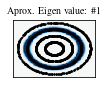

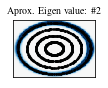

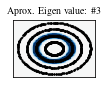

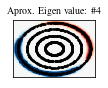

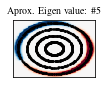

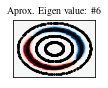

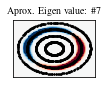

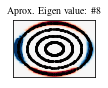

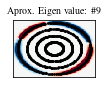

In [20]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for i in range(1, 10):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
#     fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    Z = Se[...,-i]
    ax.pcolor(X, Y, Z.reshape((num, num)) / np.sqrt(np.mean(Z**2)), cmap='RdBu_r', vmin=-1.2, vmax=1.2)
    ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
    ax.set_title(r'Aprox. Eigen value: \#{}'.format(i), size=10)
    plt.tight_layout()
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylim(-4.5, 4.5)
    ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
#     fig.savefig('savings/eigen{}.pdf'.format(i))

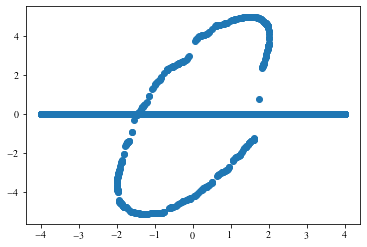

In [25]:
Se = SS @ e
i = 10
plt.scatter(x_train[..., 0], Se[..., -i])

(10000,)

Full solution

In [26]:
B = TZ @ TZ.transpose()
B /= n
A = ST.transpose() @ ST
A /= n
# A = ST.transpose()[..., :nl] @ ST[:nl]
# A /= nl

In [27]:
B += mu * TT
B += 10**(-7) * np.eye(B.shape[0])

In [28]:
v, e = eigh(A, B, subset_by_index = [A.shape[0]-10, A.shape[0]-1])

In [29]:
Se = S_test_T @ e

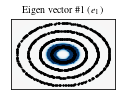

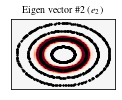

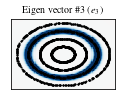

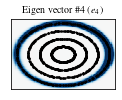

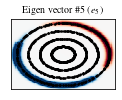

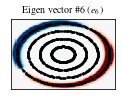

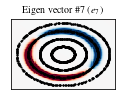

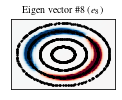

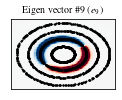

In [30]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for i in range(1, 10):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
#     fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    Z = Se[...,-i]
    ax.pcolor(X, Y, Z.reshape((num, num)) / np.sqrt(np.mean(Z**2)), cmap='RdBu_r', vmin=-1.2, vmax=1.2)
    ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
    ax.set_title(r'Eigen vector \#{} ($e_{}$)'.format(i, i), size=10)
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylim(-4.5, 4.5)
    ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
#     fig.savefig('savings/eigen{}_f.pdf'.format(i))

Eigen value decomposition of the ERM operator

In [27]:
lambd = 1e0
mu = 1/n

In [28]:
A_d = TZ @ TZ.transpose()
A_d /= n
A_d *= lambd

# A = ST.transpose()[..., :nl] @ ST[:nl]
# A /= nl
A = ST.transpose() @ ST
A /= n
A = A_d
A += mu * TT

b = ST.transpose()[..., :nl] @ s_train[:nl]

In [29]:
v, e = eigh(A, subset_by_index = [A.shape[0]-10, A.shape[0]-1])
# v, e = eigh(A, subset_by_index = [0, 10])

In [30]:
Se = S_test_T @ e

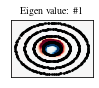

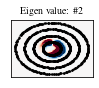

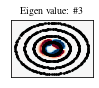

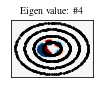

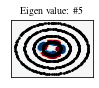

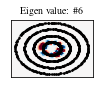

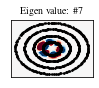

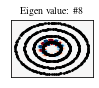

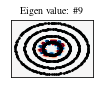

In [31]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for i in range(1, 10):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
#     fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    Z = Se[...,-i]
    ax.pcolor(X, Y, Z.reshape((num, num)) / np.sqrt(np.mean(Z**2)), cmap='RdBu_r', vmin=-1.2, vmax=1.2)
    ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
    ax.set_title(r'Eigen value: \#{}'.format(i), size=10)
    plt.tight_layout()
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylim(-4.5, 4.5)
    ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
#     fig.savefig('savings/eigen{}_f.pdf'.format(i))